In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc21 = nn.Linear(512, latent_dim)  # Mean
        self.fc22 = nn.Linear(512, latent_dim)  # Log variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))  # Assuming input_dim is 784 for an MNIST image
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


c:\Users\linry.PREVAS\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class NoisyMNISTDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        clean_image, label = self.mnist_dataset.dataset[idx]

        # Add Gaussian noise
        noise = 0.5*torch.randn_like(clean_image)
        noisy_image = clean_image + noise

        return noisy_image, clean_image  # Return the noisy image and the original as the target

# Load the dataset
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x + 0.5*torch.randn_like(x)  # Adding Gaussian noise
])

train_dataset = MNIST(root='./data', train=True, transform=mnist_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(
  root = 'data',
  train = False,
  transform = ToTensor()
  )
# Create a noisy test dataset
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=64)
noisy_test_dataset = NoisyMNISTDataset(test_data)
test_loader = DataLoader(noisy_test_dataset, batch_size=64, shuffle=True)


In [3]:
# Adjusted Loss Function with MSE
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')  # Assuming input_dim is 784

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD


In [4]:
# Model, Optimizer, and Loss Function
model = VAE(input_dim=784, latent_dim=20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Check if a GPU is available and use it; otherwise, fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

# Adjusted Training Loop
for epoch in range(25):  # Train for 10 epochs
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # If using a GPU, ensure data and model are on the same device
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # evaluate the model after every epoch
    with torch.no_grad():
        # evaluate the cost function on the test data set
        accumulated_loss = 0
        for noisy_images, clean_images in test_loader:
            noisy_images = noisy_images.to(device)
            clean_images = clean_images.to(device)
            recon_batch, mu, logvar = model(data)
            accumulated_loss += loss_function(recon_batch, data, mu, logvar)

        # update statistics
    test_loss = (accumulated_loss / len(test_dataset))

    print(f'Epoch {epoch}, Train loss: {train_loss / len(train_loader.dataset)}, Test loss: {test_loss}')



Epoch 0, Train loss: 237.53093904622395, Test loss: 2.209024667739868
Epoch 1, Train loss: 229.61124676106772, Test loss: 2.206385850906372
Epoch 2, Train loss: 228.27082958984374, Test loss: 2.1578893661499023
Epoch 3, Train loss: 227.66043771972656, Test loss: 2.2226815223693848
Epoch 4, Train loss: 227.2513025472005, Test loss: 2.162837028503418
Epoch 5, Train loss: 227.13260020345052, Test loss: 2.1436126232147217
Epoch 6, Train loss: 226.71318955891928, Test loss: 2.173112154006958
Epoch 7, Train loss: 226.61373557128906, Test loss: 2.146336793899536
Epoch 8, Train loss: 226.49125135091145, Test loss: 2.192368745803833
Epoch 9, Train loss: 226.3119896402995, Test loss: 2.184635877609253
Epoch 10, Train loss: 226.2060969482422, Test loss: 2.1488330364227295
Epoch 11, Train loss: 226.12201577148437, Test loss: 2.1810996532440186
Epoch 12, Train loss: 226.08155687662762, Test loss: 2.1582396030426025
Epoch 13, Train loss: 225.90445076497394, Test loss: 2.163865327835083
Epoch 14, Tra

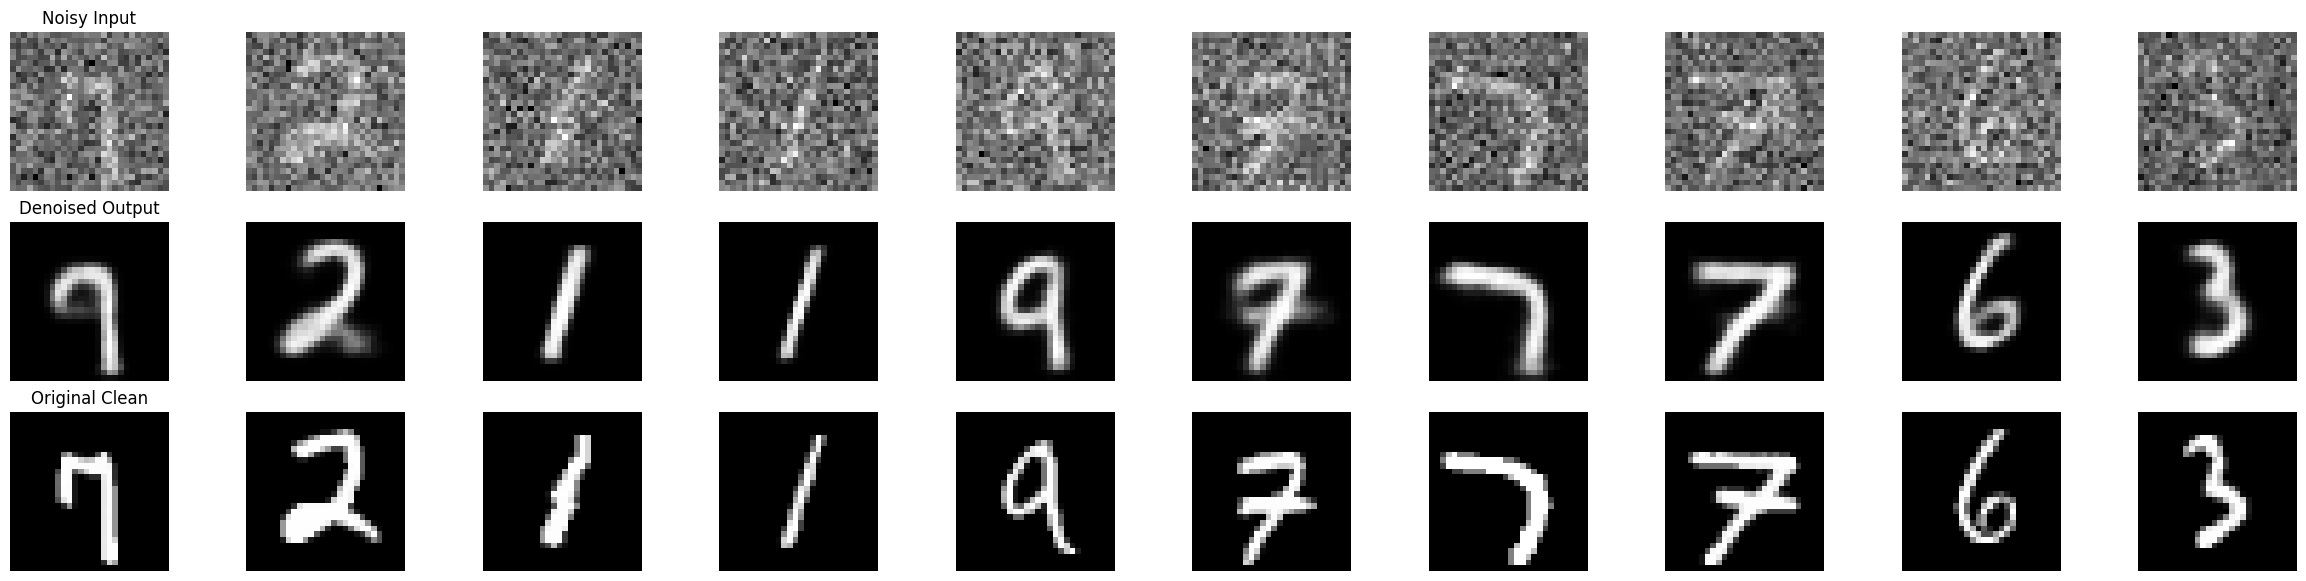

In [51]:
device = torch.device("cpu")
model.to(device)
def visualize_denoising(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        for noisy_images, clean_images in test_loader:
            outputs, mu, logvar = model(noisy_images)  # Get model predictions
            # Convert the first 10 images in the batch from PyTorch tensors to NumPy arrays
            noisy_images = noisy_images[:10].numpy()
            clean_images = clean_images[:10].numpy()
            outputs = outputs[:10].numpy()

            # Plotting
            fig, axes = plt.subplots(3, 10, figsize=(30, 7))
            for i in range(10):
                # Noisy images
                ax = axes[0, i]
                ax.imshow(noisy_images[i].squeeze(), cmap='gray')
                ax.axis('off')
                if i == 0:
                    ax.set_title('Noisy Input')

                # Denoised images (model output)
                ax = axes[1, i]
                ax.imshow(outputs[i].reshape([28,28]).squeeze(), cmap='gray')
                ax.axis('off')
                if i == 0:
                    ax.set_title('Denoised Output')

                # Original clean images
                ax = axes[2, i]
                ax.imshow(clean_images[i].squeeze(), cmap='gray')
                ax.axis('off')
                if i == 0:
                    ax.set_title('Original Clean')

            plt.show()
            break  # Only show the first batch

# Assuming `model` is your trained model and `test_loader` is your noisy test dataset loader
visualize_denoising(model, test_loader)

In [47]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(32, 32, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 40)  # Assuming latent space of size 10 (for mean and log variance)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(20, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Ensure output is between 0 and 1
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return h1[:, :20], h1[:, 20:]  # Split the result into mean and log variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [19]:
def loss_function(recon_x, x, mu, logvar):
    # Adjust MSE calculation for image data
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence remains the same
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD


In [48]:
# Model, Optimizer, and Loss Function
model = ConvVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Check if a GPU is available and use it; otherwise, fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)
recon_batch = []
mu = []
logvar=[]

# Adjusted Training Loop
for epoch in range(25):  # Train for 10 epochs
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # If using a GPU, ensure data and model are on the same device
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # evaluate the model after every epoch
    with torch.no_grad():
        # evaluate the cost function on the test data set
        accumulated_loss = 0
        for noisy_images, clean_images in test_loader:
            noisy_images = noisy_images.to(device)
            clean_images = clean_images.to(device)
            recon_batch, mu, logvar = model(data)
            accumulated_loss += loss_function(recon_batch, data, mu, logvar)

        # update statistics
    test_loss = (accumulated_loss / len(test_dataset))

    print(f'Epoch {epoch}, Train loss: {train_loss / len(train_loader.dataset)}, Test loss: {test_loss}')

Epoch 0, Train loss: 242.05946542154948, Test loss: 2.2311723232269287
Epoch 1, Train loss: 230.5668484049479, Test loss: 2.1875298023223877
Epoch 2, Train loss: 228.14450228678385, Test loss: 2.1515183448791504
Epoch 3, Train loss: 227.19306182454426, Test loss: 2.179569959640503
Epoch 4, Train loss: 226.6686727376302, Test loss: 2.1464502811431885
Epoch 5, Train loss: 226.21036256510416, Test loss: 2.1857564449310303
Epoch 6, Train loss: 226.05545003255207, Test loss: 2.166017532348633
Epoch 7, Train loss: 225.9038657063802, Test loss: 2.1279547214508057
Epoch 8, Train loss: 225.65240637207032, Test loss: 2.193005323410034
Epoch 9, Train loss: 225.5314926595052, Test loss: 2.11537766456604
Epoch 10, Train loss: 225.40224022623698, Test loss: 2.188812017440796
Epoch 11, Train loss: 225.3233612955729, Test loss: 2.1871538162231445
Epoch 12, Train loss: 225.22390158691405, Test loss: 2.1342029571533203
Epoch 13, Train loss: 225.21496017252605, Test loss: 2.1208033561706543
Epoch 14, Tra

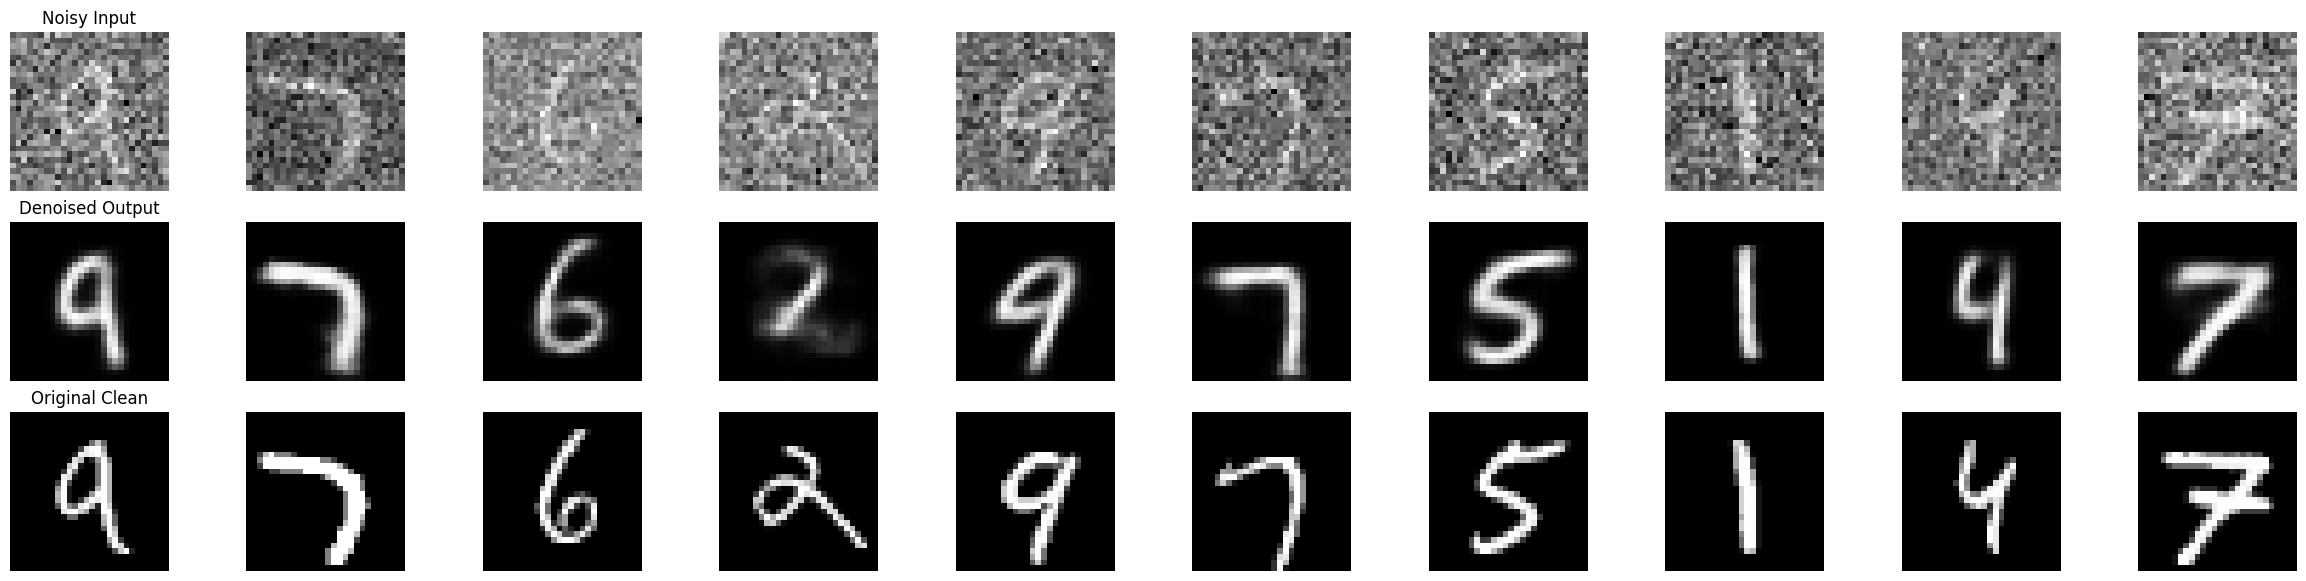

In [54]:
device = torch.device("cpu")
model.to(device)
# You can omit 'original_images' if you don't have the clean images
visualize_denoising(model, test_loader)


### `What about sound samples?`
I am using two datasets from Kaggle:

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
https://www.kaggle.com/datasets/minsithu/audio-noise-dataset?resource=download

In [ ]:
import torch
from torch import nn

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3_mu = nn.Linear(256, latent_dim)
        self.fc3_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3_mu(h), self.fc3_logvar(h)  # Returns mean and log variance

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return torch.sigmoid(self.fc3(h))  # Using sigmoid to ensure output is between 0 and 1

class AudioVAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AudioVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, input_dim))  # Assuming x is [batch_size, 22050]
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar



In [ ]:
import torchaudio
import os

def process_audio_files(folder_path, output_folder, chunk_size=44100):
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            waveform, sample_rate = torchaudio.load(file_path)

            # Assuming mono audio for simplicity. For stereo, you would need to handle both channels.
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            num_chunks = waveform.shape[1] // chunk_size
            for i in range(num_chunks):
                chunk = waveform[:, i*chunk_size:(i+1)*chunk_size]

                # Save original chunk
                torchaudio.save(os.path.join(output_folder, f"{filename}_chunk_{i}.wav"), chunk, sample_rate)
original_files_path = "..\\data\\GTZAN\\sound_samples\\"
chunks_files_path = "..\\data\\GTZAN\\audio_chunks\\"

process_audio_files(original_files_path, chunks_files_path)

In [ ]:
import os
import numpy as np
import librosa
import torch
from torch.utils.data import Dataset, DataLoader

class AudioChunkDataset(Dataset):
    def __init__(self, folder_path, noise_level=0.005, transform=None):
        self.folder_path = folder_path
        self.files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]
        self.noise_level = noise_level
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        waveform, sample_rate = torchaudio.load(file_path)

        noise = torch.randn_like(waveform) * self.noise_level
        noisy_waveform = waveform + noise

        return waveform, noisy_waveform


In [ ]:
print(len(dataloader.dataset[0][0][0]))

In [ ]:
batch_size = 100

# Example usage - specify add_noise=True for training dataset to apply noise dynamically
audio_dataset = AudioChunkDataset(chunks_files_path)
dataloader = DataLoader(audio_dataset, batch_size=batch_size, shuffle=True)

# Parameters
input_dim = 44100
latent_dim = 64  # Or any other size you wish to try
# Model, Optimizer, and Loss Function
model = AudioVAE(input_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Check if a GPU is available and use it; otherwise, fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

epochs = 10

def train(epoch):
    model.train()
    train_loss = 0
    for noisy_audio, clean_audio in dataloader:  # Assuming train_loader is defined
        clean_audio = clean_audio.to(device)  # Assuming device is defined
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(clean_audio)
        loss = loss_function(recon_batch, clean_audio, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        print(f'Training loss: {loss.item()/batch_size}')
        optimizer.step()

        #if batch_idx % log_interval == 0:  # log_interval is defined elsewhere
        #    print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item() / len(data)}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset)}')
for epoch in range(1, epochs + 1):
     train(epoch)

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

# Assuming `noisy_audio` is your input audio array sampled at 22,050 Hz
# Make sure `noisy_audio` is a numpy array with shape [22050,] for 1 second of audio

# Normalize and convert your noisy_audio to a tensor
noisy_audio_tensor = torch.FloatTensor(train_d[1][0]).view(1, -1)  # Add batch dimension

# Pass the noisy audio through the model to get the denoised version
model.eval()  # Ensure model is in evaluation mode
with torch.no_grad():
    reconstructed_audio, _, _ = model(noisy_audio_tensor)
    denoised_audio = reconstructed_audio.view(-1).cpu().numpy()  # Remove batch dimension and convert to numpy

# Sampling rate
sr = 22050

# Plotting
plt.figure(figsize=(15, 6))

# Original Noisy Audio
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, 1, len(train_d[1][0])), train_d[1][0])
plt.title('Original Noisy Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Denoised Audio
plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, 1, len(denoised_audio)), denoised_audio)
plt.title('Denoised Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Listen to the Original Noisy Audio
print("Original Noisy Audio:")
display(Audio(train_d[1][0], rate=sr))

# Listen to the original Audio
print("Original Audio:")
display(Audio(train_d[0][0], rate=sr))

# Listen to the Denoised Audio
print("Denoised Audio:")
display(Audio(denoised_audio, rate=sr))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fft_on_chunks(audio, chunk_size=1024):
    """
    Perform FFT on audio chunks and return the average magnitude spectrum.

    Parameters:
    - audio: The audio signal array.
    - chunk_size: Size of each chunk for FFT.

    Returns:
    - freqs: Frequencies corresponding to the magnitude spectrum.
    - avg_magnitude: Average magnitude spectrum of the chunks.
    """
    # Number of chunks
    num_chunks = len(audio) // chunk_size

    # Initialize the sum of magnitude spectra
    magnitude_sum = np.zeros(chunk_size // 2 + 1)

    # Process each chunk
    for i in range(num_chunks):
        # Extract the chunk
        chunk = audio[i*chunk_size:(i+1)*chunk_size]

        # Apply FFT
        fft_result = np.fft.rfft(chunk)

        # Compute magnitude
        magnitude = np.abs(fft_result)

        # Accumulate the magnitude
        magnitude_sum += magnitude

    # Compute average magnitude spectrum
    avg_magnitude = magnitude_sum / num_chunks

    # Frequency axis
    freqs = np.fft.rfftfreq(chunk_size, d=1./22050)

    return freqs, avg_magnitude

# Assuming `noisy_audio` and `denoised_audio` are your input and output arrays
chunk_size = 2048  # Example chunk size, can be adjusted

# Compute average magnitude spectrum for noisy and denoised audio
freqs_noisy, avg_magnitude_noisy = fft_on_chunks(noisy_audio, chunk_size=chunk_size)
freqs_denoised, avg_magnitude_denoised = fft_on_chunks(denoised_audio, chunk_size=chunk_size)

# Plotting
plt.figure(figsize=(14, 6))

# Noisy Audio Spectrum
plt.subplot(1, 2, 1)
plt.plot(freqs_noisy, avg_magnitude_noisy)
plt.title('Average Magnitude Spectrum (Noisy)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

# Denoised Audio Spectrum
plt.subplot(1, 2, 2)
plt.plot(freqs_denoised, avg_magnitude_denoised)
plt.title('Average Magnitude Spectrum (Denoised)')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()
